In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

In [2]:
stringSST = "300" ##295, 300 or 305
n_days = 25

#TOOCAN segmentation masks (les labels des objets MCS, dans la grille originale x,y,t)
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/TOOCAN_2.07_SAM_RCE_large'+stringSST+'_2D_irtb.nc'

# TOOCAN objects (list d'objets MCS, leur labels et leur caractéristiques)
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/FileTracking/TOOCAN-SAM_RCE_large'+stringSST+'_2D_irtb.dat.gz'

sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [3]:
icon_seg = "/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_01/irtb/TOOCAN_2.07_ICON_large300_2D_irtb.nc"
mesonh_seg = "/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_01/irtb/TOOCAN_2.07_MESONH_large300_2D_irtb.nc"

# Let's Big Data

In [4]:
chunk_size = {'time' :48, 'x' : 32, 'y' : 32}
label_chunk_size = {'time' :48, 'longitude' : 32, 'latitude' : 32}

## Open Precip data under ds

In [5]:
# Create a Dask client
client = ddistributed.Client()

# Open native precip datasets
ds1 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_1.nc", chunks=chunk_size)
ds2 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_2.nc", chunks=chunk_size)

# Combine datasets
ds = xr.concat([ds1, ds2], dim='time')
# Rename dimensions
ds["x"] = ((ds["x"])/3e3).astype(int)
ds["y"] = (ds["y"]/3e3).astype(int) 
ds["time"] = np.round(((ds["time"]-75)*48)).astype(int)
ds = ds.isel(time = slice(0, 48*n_days)) 

distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-fdss_2ak', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-ld2m823v', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-t7t2ui8v', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-zn9ziupi', purging


In [6]:
filename = 'dist_SAM_Native_Prec_sizemax_1e7.pkl' # used for import or saving the object
path = '/homedata/mcarenso/distrib_nd5/'  # my desired directory path

# Check if the file exists
if os.path.isfile(os.path.join(path, filename)):
    # File exists, load the object
    with open(os.path.join(path, filename), 'rb') as file:
        dist_SAM_Prec = pickle.load(file)
else:
    # File doesn't exist, create the object
    dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
    dist_SAM_Prec.computeDistribution(sample = ds["Prec"].stack(flat=('time', 'y', 'x')).to_numpy())
    dist_SAM_Prec.storeSamplePoints(sample = ds["Prec"].stack(flat=('time', 'y', 'x')).to_numpy(), sizemax = int(1e7))

    # Save the object as a file
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(dist_SAM_Prec, file)

In [7]:
size = dist_SAM_Prec.size
ds_SAM_shape = (size//(128*2048), 128, 2048)

## Open MCS_list and extract the 6hours 10hours MCS and pot some of their data distrib

In [8]:
## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
MCS_labels = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file

def idx_by_label(labels, label_list = MCS_labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

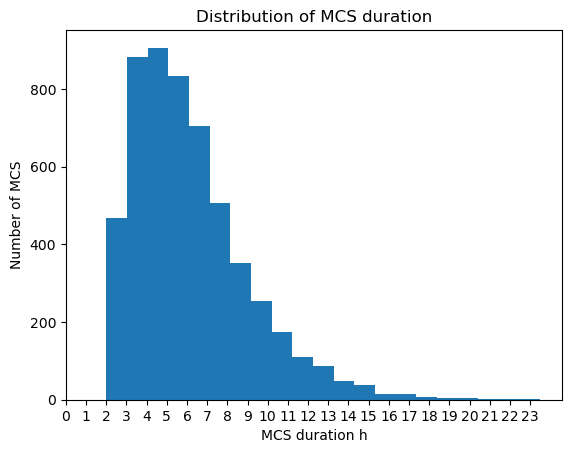

In [9]:
%matplotlib inline
MCS_durations = [MCS[i].duration for i in range(len(MCS))]
# plot the distribution of MCS duration
plt.hist([MCS[i].duration for i in range(len(MCS))], bins = (max(MCS_durations)- min(MCS_durations))//2)

#xticks are half hourly make them hourly
tick_locs = np.arange(0, max(MCS_durations), 2)
tick_labels = np.arange(0, max(MCS_durations),2)//2
plt.xticks(tick_locs, tick_labels)

plt.xlabel("MCS duration h")
plt.ylabel("Number of MCS")
plt.title("Distribution of MCS duration")
plt.show()

In [10]:
MCS_6h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in [11,12,13]]
MCS_6h_labels = [MCS_6h[i].label for i in range(len(MCS_6h))]

MCS_2h_to_10h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in np.arange(4, 21, 1).astype(int).tolist()]
MCS_2h_to_10h_labels = [MCS_2h_to_10h[i].label for i in range(len(MCS_2h_to_10h))]

## Create masks (bools or labels)

In [11]:
## label_mask contains the label of the MCS over the map
label_mask = xr.open_dataarray(file_seg).isel(time=slice(48*n_days)).chunk(label_chunk_size)

# Put to nan the labels that are not in MCS_6h_labels
label_6h_mask = label_mask.where(label_mask.isin(MCS_6h_labels))

label_2h_to_10h_mask = label_mask.where(label_mask.isin(MCS_2h_to_10h_labels))

# mask contains the mask True or False if there is an MCS at this position over the map
mask_6h = ~label_6h_mask.where(label_6h_mask.isnull(), False).isnull()

mask_2h_to_10h = ~label_2h_to_10h_mask.where(label_2h_to_10h_mask.isnull(), False).isnull()
# da contains the native precipitation values over the map filtered where there is an MCS
# Prec = ds["Prec"].where(mask_6h)

## Create Time_array, and then Age_array

In [12]:
## TODO : read about numpy broadcasting
from myFuncs import createTimeArray
path = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'time_array_6h_3element.pkl' # used for import or saving the object

## save time_array under a pickle file in homedata, with a name specific to the 11,12,13 1/2h MCS
if os.path.isfile(os.path.join(path, filename)):
    # File exists, load the object
    with open(os.path.join(path, filename), 'rb') as file:
        time_array_6h = pickle.load(file)
else:
    # File doesn't exist, create the object
    time_array_6h = createTimeArray(mask_6h)
    # save itto a pickle file
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(time_array_6h, file)
    

In [61]:
# Define the function to map labels to MCS values and vectorize it
def Age(label, time, mcs):
    """MCS and labels must be indexed in the same fashion"""
    if ~np.isnan(label): 

        time_init = mcs.TimeInit
        duration = mcs.duration
        age = (time - time_init + 2)/duration

        return age, duration, time_init if age != 0 else None
    else:
        return None
    
def Age_vec(label_mask, time_array, MCS, labels):
    out = [np.array([]), np.array([]), np.array([])]
    for i, label in enumerate(label_mask):
        time = time_array[i]
        idx = labels.index(label)
        mcs = MCS[idx]
        age, dur, timi = Age(label, time, mcs)
        out[0] = np.append(out[0], age)
        out[1] = np.append(out[1], dur)
        out[2] = np.append(out[2], timi)
        
    return out  ## works cause first dimension of label_mask is time

In [14]:
path = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'age_array_6h_3element.pkl' # used for import or saving the object
# load age_array if exist or create it
if os.path.isfile(os.path.join(path, filename)):
    #load it 
    with open(os.path.join(path, filename), 'rb') as file:
        age_array_6h_3element = pickle.load(file)
else:
    # create it
    age_array_6h_3element = Age_vec(label_6h_mask.data.compute().flatten())
    # save it
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(age_array_6h_3element, file)

# Compute Analysis of Normalzied Age of MCS over XPrecip bins for MCS around 6h lifetime

In [71]:
from collections import defaultdict
import time 

def computeAgeAnalysisOverBins(self,sample, MCS_list = MCS_2h_to_10h, label = None, sizemax=5000, verbose=False, skip_to_X = False, method = 'iterative reducing'):
    """
    MCS_list and label are built over the TOOCAN files, so they could not be specified and instead simply be read from the file, let's keep it like that for clarity for now
    
    This function doesn't require bin_locations to be stored as it will recomputed everything mask per bin,
    but it will be much faster as it will reduce the size of the arrays after each bin computation.
    
    First output is the data with no treatmeant over bins
    
    the other outputs are optionnal and are computed only if the label array of MCS is provided
    they consist of an analysis of bins>40 so the extremes only
    
    grouped_data is the data aggregated by grouping, quite straightforward
    the 2 following are ordered to correspond to grouped_data 
    values_over_labels is the sum of the values of sample divided by the distinct counts of labels. 
    grouped_counts represent this distinct count of labels
    """
    ## Measure time of init phase 
    t0 = time.time()

    ## Treat MCS_list to extract the labels 
    MCS_labels = [MCS_list[i].label for i in range(len(MCS_list))]
    
    ## Instantiate label_mask then time_array and flatten it as to match label and sample
    mask_label = ~np.isnan(label)
    time_array = createTimeArray(mask_label).flatten()

    ## flatten sample and label
    sample = sample.flatten()
    label = label.flatten()

    ## instantiate data over bins, and data over duration lists
    data_over_bins  = [[] for _ in range(self.nbins)]
    
    ## these actually depends of the durations of MCS studied.. for now 2h to 10h MCS
    MCS_duration_list = np.arange(4, 21, 1).astype(int).tolist() # [4, 5, ..., 20]
    ages_per_duration = [[] for i in range(len(MCS_duration_list))]

    ## instantiate the list that will be use for theAge Analysis
    XSample_data = []
    XSample_values = []
    XSample_labels = []
    XSample_duration = []


    ## print time of init phase
    print("init phase : ", time.time()-t0)
    
    if method == 'iterative reducing':
        # Store a tmp for each array
        first_bin = True
        tmp_sample = sample.copy()
        tmp_label = label.copy()
        
        for i_bin, bin_size in enumerate(self.bin_sample_size):
            ## measure time for each loop
            t0 = time.time()
            if bin_size == 0 : continue
            elif bin_size !=0:
                if first_bin :  ## this is the first bin, we need to remove the nan values and then create a mask that only keeps a certain ratio of the points choosen randomly
                    time_array = time_array[~np.isnan(tmp_sample)]                    
                    tmp_label = tmp_label[~np.isnan(tmp_sample)]
                    tmp_sample = tmp_sample[~np.isnan(tmp_sample)]
                    first_bin = False
                
                
                    # create a random mask that contains a certain ratio of true elements that correspond to the ration of the next 2 bins 
                    first_excess_amount = bin_size - sizemax
                    mask_excess = np.logical_and(tmp_sample.flatten() >= self.bins[i_bin], tmp_sample.flatten() < self.bins[i_bin+1])
                    # Indices of True values in the mask array
                    true_indices = np.where(mask_excess)[0]
                    
                    # Randomly select indices to change to False
                    false_indices = np.random.choice(true_indices, size=first_excess_amount, replace=False)
                    # Change the selected indices to False
                    first_mask = mask_excess.copy()
                    first_mask[false_indices] = False

                    print(np.shape(first_mask) ,tmp_sample.shape, time_array.shape, tmp_label.shape)
                    first_mask_no_nan = first_mask[~np.isnan(tmp_sample)]
                    
                    first_time_array = time_array[first_mask_no_nan]
                    first_label = tmp_label[first_mask_no_nan]
                    

                    #compute data_over_bin according to label over mask and time_array info crossed by MCS list
                    out = Age_vec(first_label, first_time_array, MCS_list, MCS_labels)
                    ages = out[0]
                    ages_no_nan = ages[~np.isnan(ages)]
                    data_over_bins[i_bin]  = ages_no_nan
                    
                    tmp_sample = tmp_sample[~mask_excess]
                    time_array = time_array[~mask_excess]
                    tmp_label = tmp_label[~mask_excess]
                
                else : 
                    mask = np.logical_and(tmp_sample.flatten() >= self.bins[i_bin], tmp_sample.flatten() < self.bins[i_bin+1])
                    
                    # put mask_no_nan to False if Xsample_labels is nan
                    mask_no_nan = np.logical_and(mask, ~np.isnan(tmp_label)) 
                                            
                    # compute output with no nan
                    out = Age_vec(tmp_label[mask_no_nan], time_array[mask_no_nan], MCS_list, MCS_labels)
                    ages = out[0]
                    duration = ages[1]
                    if i_bin >= 40 and label is not None:
                        # update list for Age Analysis Xetremes only
                        XSample_data.extend(ages)
                        XSample_values.extend(tmp_sample[mask_no_nan])
                        XSample_labels.extend(tmp_label[mask_no_nan])
                        XSample_duration.extend(duration)
                               
                    ## add data over bins
                    data_over_bins[i_bin]  = ages
                    
                    ## reduce tmp array according to ~mask
                    tmp_sample = tmp_sample[~mask]
                    time_array = time_array[~mask]                   
                    tmp_label = tmp_label[~mask] 

            ## print time of each loop
            print("loop ", i_bin, " : ", time.time()-t0)
            
    for age, duration in zip(XSample_data, XSample_duration):
        for i, MCS_duration in enumerate(MCS_duration_list):
            if duration == MCS_duration:
                ages_per_duration[i].append(age)
            
    ## initialize the dictionnary that creates dictionnary if given a new key (age = x = data)
    data_dict = defaultdict(lambda: {'values': 0, 'distinct_labels': []})
    
    # fill that dict
    for x, value, label in zip(XSample_data, XSample_values, XSample_labels):
        data_dict[x]['values'] += value
        if label not in data_dict[x]['distinct_labels']:
            data_dict[x]['distinct_labels'].append(label)
        
    ## group by keys and sum the values divided by the number of distinct labels 
    grouped_data = np.sort(list(data_dict.keys()))
    grouped_values = [data_dict[data]['values'] for data in grouped_data]
    grouped_counts = [len(data_dict[data]['distinct_labels']) for data in grouped_data]
    values_over_labels = [value/count for value, count in zip(grouped_values, grouped_counts)] 
    
    ## return data over bins, ages of Xprecip, and Xprecip over this ages 
    return((data_over_bins, grouped_data, values_over_labels, grouped_counts, ages_per_duration))

In [16]:
# tmp_sample = ds["Prec"].values.flatten()
# tmp_label = label_2h_to_10h_mask.compute().values.flatten()
# time_array = createTimeArray(tmp_label).flatten()

# MCS_duration_list = np.arange(4, 21, 1).astype(int).tolist() # [4, 5, ..., 20]
# ages_per_duration = [[] for i in range(len(MCS_duration_list))]

# mask = np.logical_and(tmp_sample >= dist_SAM_Prec.bins[40], tmp_sample < dist_SAM_Prec.bins[41])
# mask_no_nan = np.logical_and(mask, ~np.isnan(tmp_label))

# ages = Age_vec(tmp_label[mask_no_nan], time_array[mask_no_nan], MCS_2h_to_10h, MCS_2h_to_10h_labels)

# idxs = idx_by_label(tmp_label[mask_no_nan], MCS_2h_to_10h_labels)
# durations  = [MCS_2h_to_10h[idx].duration for idx in idxs]

# ça marche la 

In [72]:
filename = "AgaAnalysis.pkl"
path_data = "/homedata/mcarenso/Stage2023/SAM/300K/"
## if file exists, load it
if os.path.isfile(path_data + filename):
    with open(os.path.join(path_data, filename), 'rb') as file:
        output = pickle.load(file)
        
else : 
    ## compute the age analysis
    output = computeAgeAnalysisOverBins(dist_SAM_Prec, sample = ds["Prec"].values, MCS_list = MCS_2h_to_10h, label = label_2h_to_10h_mask.compute().values, sizemax = int(1e7))
    
    ## save the output
    with open(os.path.join(path_data, filename), 'wb') as file:
        pickle.dump(output, file)

In [54]:
Ages_over_bins, Ages_of_Xprecip, Xprecip_over_ages, Xprecip_counts, Ages_per_duration = output

In [ ]:
data = ds["Prec"].values.flatten()

In [20]:
maskp = np.logical_and(data >= dist_SAM_Prec.bins[40], data < dist_SAM_Prec.bins[41])
mask_no_nan = np.logical_and(maskp, ~np.isnan(label_2h_to_10h_mask.compute().values.flatten()))
tmp_sample = ds["Prec"].values.flatten()[mask_no_nan]
tmp_label = label_2h_to_10h_mask.compute().values.flatten()[mask_no_nan]
time_array = createTimeArray(tmp_label).flatten()
MCS_list = MCS_2h_to_10h
MCS_labels = MCS_2h_to_10h_labels

XSample_data = []
XSample_values = []
XSample_labels = []
XSample_duration = []
MCS_duration_list = np.arange(4, 21, 1).astype(int).tolist() # [4, 5, ..., 20]
Ages_per_duration = [[] for i in range(len(MCS_duration_list))]

In [65]:
# compute ages
out = Age_vec(tmp_label, time_array, MCS_list, MCS_labels)

In [66]:
ages = out[0]
durations = out[1]

In [67]:


# update list for Age Analysis
XSample_data.extend(ages)
XSample_values.extend(tmp_sample)
XSample_labels.extend(tmp_label)
XSample_durations.extend(durations)

In [38]:
Ages_per_duration

[[array([], shape=(0, 3670), dtype=float64), array([], dtype=float64)],
 [array([], shape=(0, 3670), dtype=float64),
  array([246.8, 256.8, 264.2, 265.2, 311.6, 408.8, 412.2, 444. ]),
  246.8,
  256.8,
  264.2,
  265.2,
  311.6,
  408.8,
  412.2,
  444.0],
 [array([], shape=(0, 3670), dtype=float64),
  array([ 34.        ,  51.        ,  75.33333333, 108.66666667,
         135.5       , 135.66666667, 156.5       , 157.        ,
         167.        , 177.5       , 180.16666667, 183.33333333,
         201.66666667, 231.16666667, 313.66666667, 318.16666667,
         367.5       , 384.16666667, 409.5       , 410.33333333,
         410.5       , 411.5       , 411.66666667, 412.        ,
         412.16666667]),
  34.0,
  51.0,
  75.33333333333333,
  108.66666666666667,
  135.5,
  135.66666666666666,
  156.5,
  157.0,
  167.0,
  177.5,
  180.16666666666666,
  183.33333333333334,
  201.66666666666666,
  231.16666666666666,
  313.6666666666667,
  318.1666666666667,
  367.5,
  384.166666666666

In [24]:
# filename = 'Xprecip_by_ages_6h_3element.pkl' # used for import or saving the object   
# path_data = '/homedata/mcarenso/data/'

# # Check if the file exists
# if os.path.isfile(os.path.join(path_data, filename)):
#     # Load the objects from the file
#     with open(os.path.join(path_data, filename), 'rb') as file:
#         saved_data = pickle.load(file)
#         Age_Over_bins_6h_3element = saved_data['Age_Over_bins_6h_3element']
#         Ages_of_Xprecip_6h_3elements = saved_data['Ages_of_Xprecip_6h_3elements']
#         Xprecip_6h_3elements = saved_data['Xprecip_6h_3elements']
#         Number_of_MCS_of_6h_3elements_per_age = saved_data['Number_of_MCS_of_6h_3elements_per_age']
# else:
#     # Compute the data
#     Age_Over_bins_6h_3element, Ages_of_Xprecip_6h_3elements, Xprecip_6h_3elements, Number_of_MCS_of_6h_3elements_per_age = dist_SAM_Prec.computeDataOverBins(sample=ds["Prec"].values, data=age_array_6h_3element, label=label_6h_mask.values, sizemax=int(1e7), method  = 'iterative reducing')
    
#  # Create a dictionary to store the objects
# saved_data = {
#     'Age_Over_bins_6h_3element': Age_Over_bins_6h_3element,
#     'Ages_of_Xprecip_6h_3elements': Ages_of_Xprecip_6h_3elements,
#     'Xprecip_6h_3elements': Xprecip_6h_3elements, 
#     'Number_of_MCS_per_age': Number_of_MCS_of_6h_3elements_per_age
# }

# # Save the dictionary to the file
# with open(os.path.join(path_data, filename), 'wb') as file:
#     pickle.dump(saved_data, file)


## Plot Ages over bins

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


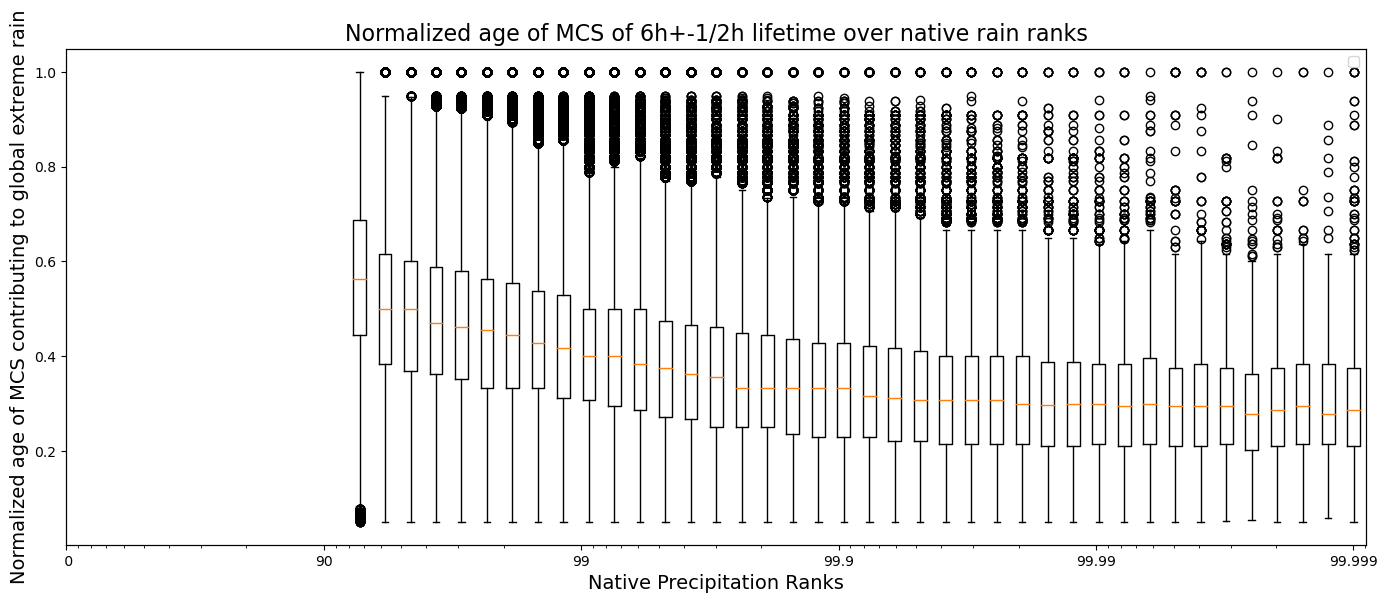

In [25]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=dist_SAM_Prec.ranks

setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(Ages_over_bins)
ax_show.set_xticks([])

ax.set_xlabel("Native Precipitation Ranks", fontsize = 14)

ax.set_ylabel("Normalized age of MCS contributing to global extreme rain", fontsize = 14)
plt.legend()
plt.title("Normalized age of MCS of 6h+-1/2h lifetime over native rain ranks", fontsize = 16)
plt.tight_layout()
plt.show()

## Plot Xprecip over ages for 6h MCS 3 elements

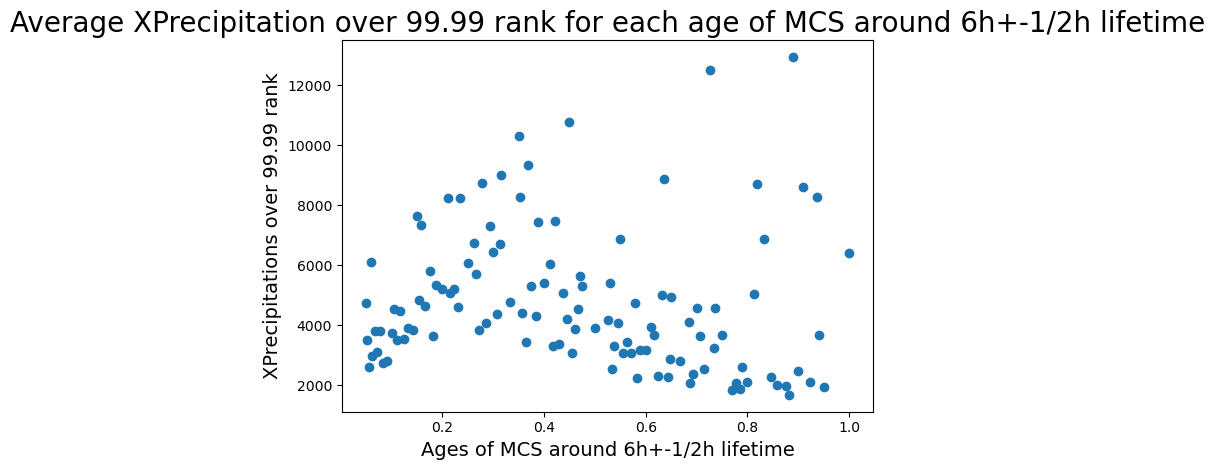

In [26]:
plt.scatter(Ages_of_Xprecip, Xprecip_over_ages)
plt.xlabel('Ages of MCS around 6h+-1/2h lifetime', fontsize = 14)
plt.ylabel('XPrecipitations over 99.99 rank', fontsize = 14)
plt.title('Average XPrecipitation over 99.99 rank for each age of MCS around 6h+-1/2h lifetime', fontsize = 20)
plt.tight_layout()
plt.show()

## Plot #MCS over ages for 6h MCS 3 elements

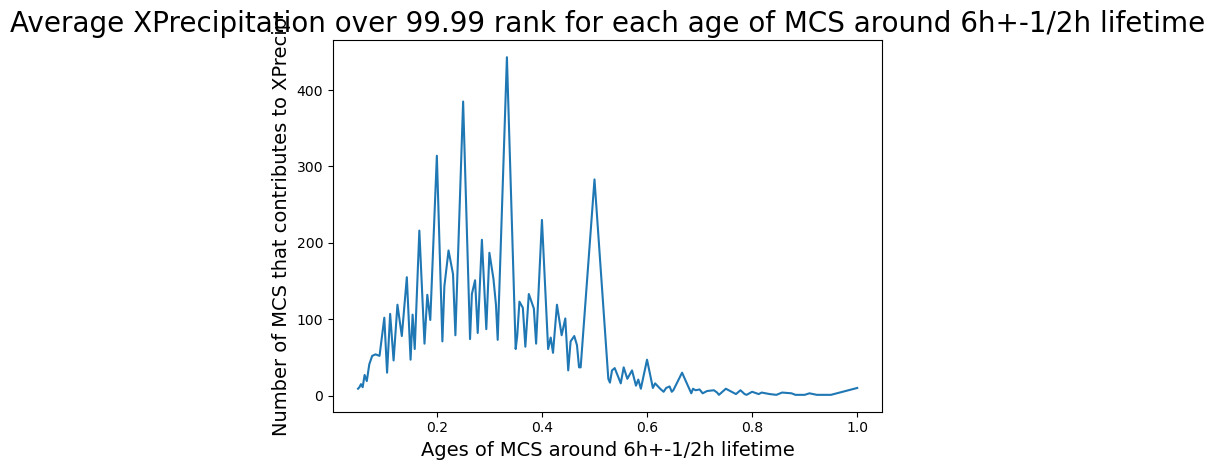

In [27]:
plt.plot(Ages_of_Xprecip, Xprecip_counts)
plt.xlabel('Ages of MCS around 6h+-1/2h lifetime', fontsize = 14)
plt.ylabel('Number of MCS that contributes to XPrecip', fontsize = 14)
plt.title('Average XPrecipitation over 99.99 rank for each age of MCS around 6h+-1/2h lifetime', fontsize = 20)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


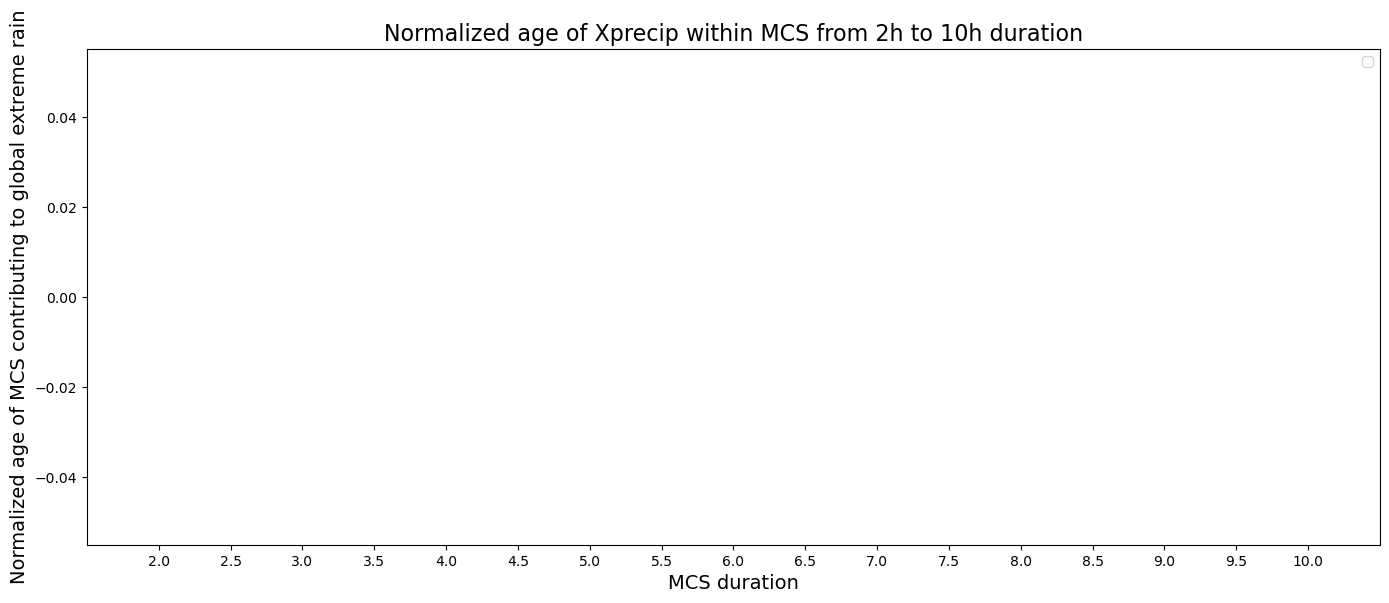

In [31]:
%matplotlib inline

MCS_duration_2h_to_10h = np.arange(2, 10.5, 1/2)

fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
ax.boxplot(Ages_per_duration, positions = MCS_duration_2h_to_10h, widths = 0.3)


ax.set_xlabel("MCS duration", fontsize = 14)
ax.set_ylabel("Normalized age of MCS contributing to global extreme rain", fontsize = 14)
plt.legend()
plt.title("Normalized age of Xprecip within MCS from 2h to 10h duration", fontsize = 16)
plt.tight_layout()
plt.show()


# Build time and age array, with MCS from 2h to 10h 

In [29]:
## TODO : read about numpy broadcasting
from myFuncs import createTimeArray
path = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'time_array_2h_to_10h_MCS.pkl' # used for import or saving the object

## save time_array under a pickle file in homedata, with a name specific to the 11,12,13 1/2h MCS
if os.path.isfile(os.path.join(path, filename)):
    # File exists, load the object
    with open(os.path.join(path, filename), 'rb') as file:
        time_array_2h_to_10h = pickle.load(file)
else:
    # File doesn't exist, create the object
    time_array_2h_to_10h = createTimeArray(mask_2h_to_10h)
    # save itto a pickle file
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(time_array_2h_to_10h, file)
    

In [30]:
path = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'age_array_2h_to_10h_MCS.pkl' # used for import or saving the object
# load age_array if exist or create it
if os.path.isfile(os.path.join(path, filename)):
    #load it 
    with open(os.path.join(path, filename), 'rb') as file:
        age_array_2h_to_10h = pickle.load(file)
else:
    # create it
    age_array_2h_to_10h = Age_vec(label_2h_to_10h_mask.data.compute().flatten(), time_array_2h_to_10h, MCS=MCS_2h_to_10h, labels=MCS_2h_to_10h_labels)
    # save it
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(age_array_2h_to_10h, file)

# Compute Analysis of Normalized Age of MCS over XPrecip bins for MCS from 2h to 10h duration

In [21]:
filename = 'Xprecip_by_ages_2h_to_10h_MCS.pkl' # used for import or saving the object   
path_data = '/homedata/mcarenso/data/'

# Check if the file exists
if os.path.isfile(os.path.join(path_data, filename)):
    # Load the objects from the file
    with open(os.path.join(path_data, filename), 'rb') as file:
        saved_data = pickle.load(file)
        Age_Over_bins_2h_to_10h_MCS = saved_data['Age_Over_bins_2h_to_10h_MCS']
        Ages_of_Xprecip_2h_to_10h_MCS = saved_data['Ages_of_Xprecip_2h_to_10h_MCS']
        Xprecip_2h_to_10h_MCS = saved_data['Xprecip_2h_to_10h_MCS']
        Number_of_MCS_of_2h_to_10h_MCS = saved_data['Number_of_MCS_of_2h_to_10h_MCS_per_age']
else:
    # Compute the data
    Age_Over_bins_2h_to_10h_MCS, Ages_of_Xprecip_2h_to_10h_MCS, Xprecip_2h_to_10h_MCS, Number_of_MCS_of_2h_to_10h_MCS_per_age = dist_SAM_Prec.computeDataOverBins(sample=ds["Prec"].values, data=age_array_2h_to_10h, label=label_2h_to_10h_mask.values, sizemax=int(1e7), method  = 'iterative reducing')
    
 # Create a dictionary to store the objects
saved_data = {
    'Age_Over_bins_2h_to_10h_MCS': Age_Over_bins_2h_to_10h_MCS,
    'Ages_of_Xprecip_2h_to_10h_MCS': Ages_of_Xprecip_2h_to_10h_MCS,
    'Xprecip_2h_to_10h_MCSs': Xprecip_2h_to_10h_MCS, 
    'Number_of_2h_to_10h_MCS_per_age': Number_of_MCS_of_2h_to_10h_MCS_per_age
}

# Save the dictionary to the file
with open(os.path.join(path_data, filename), 'wb') as file:
    pickle.dump(saved_data, file)


## same plots but for 2h-10h

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


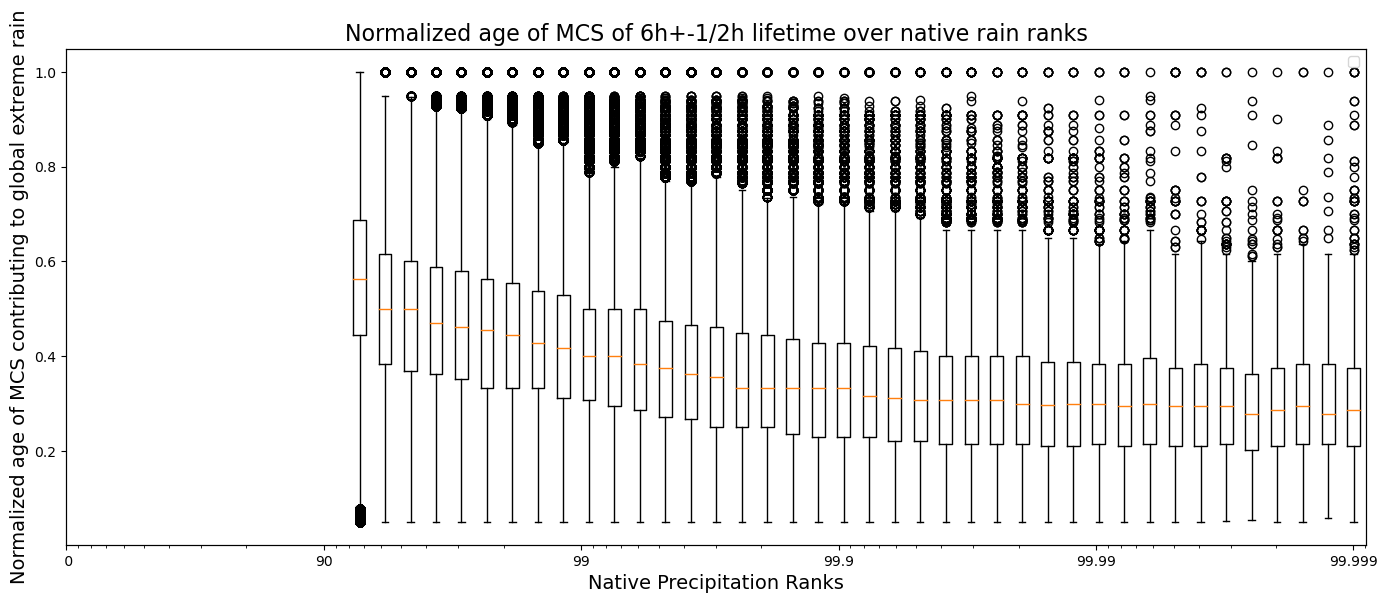

In [22]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=dist_SAM_Prec.ranks

setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(Age_Over_bins_2h_to_10h_MCS)
ax_show.set_xticks([])

ax.set_xlabel("Native Precipitation Ranks", fontsize = 14)
ax.set_ylabel("Normalized age of MCS contributing to global extreme rain", fontsize = 14)
plt.legend()
plt.title("Normalized age of MCS of 6h+-1/2h lifetime over native rain ranks", fontsize = 16)
plt.tight_layout()
plt.show()

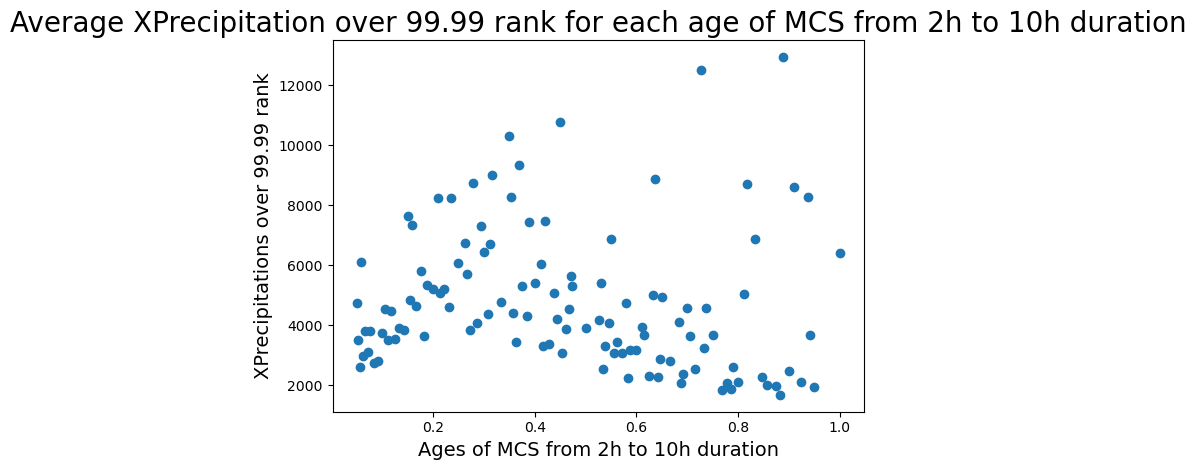

In [30]:
plt.scatter(Ages_of_Xprecip_2h_to_10h_MCS, Xprecip_2h_to_10h_MCS)
plt.xlabel('Ages of MCS from 2h to 10h duration', fontsize = 14)
plt.ylabel('XPrecipitations over 99.99 rank', fontsize = 14)
plt.title('Average XPrecipitation over 99.99 rank for each age of MCS from 2h to 10h duration', fontsize = 20)
plt.tight_layout()
plt.show()

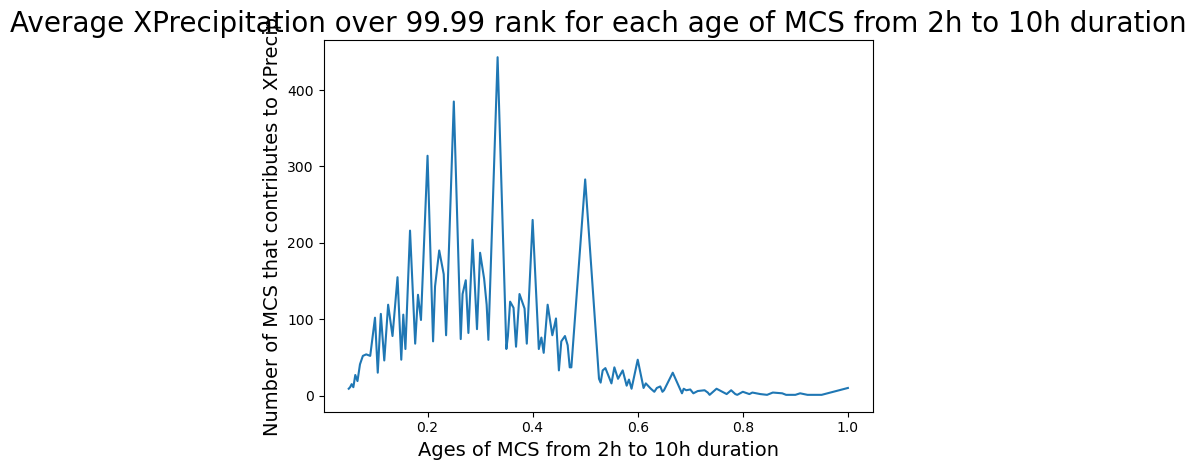

In [29]:
plt.plot(Ages_of_Xprecip_2h_to_10h_MCS, Number_of_MCS_of_2h_to_10h_MCS_per_age)
plt.xlabel('Ages of MCS from 2h to 10h duration', fontsize = 14)
plt.ylabel('Number of MCS that contributes to XPrecip', fontsize = 14)
plt.title('Average XPrecipitation over 99.99 rank for each age of MCS from 2h to 10h duration', fontsize = 20)
plt.tight_layout()
plt.show()

### Iterate over bins to compute the relative age at which extreme rains occurs in MCS over the different durations of MCS; TODO add it in the computeAgeOverBins

In [32]:
## save age_array_list 
path = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'ages_per_duration_2h_to_10h_MCS.pkl' # used for import or saving the object


# load age_array if exist or create it  
if os.path.isfile(os.path.join(path, filename)):
    #load it 
    with open(os.path.join(path, filename), 'rb') as file:
        ages_per_duration = pickle.load(file)

else:
    # build it 
    MCS_duration_list = np.arange(4, 21, 1).astype(int).tolist() # [4, 5, ..., 20]
    ## create a list of empty arrays to store the age of MCS of different duration
    ages_per_duration = [[] for i in range(len(MCS_duration_list))]

    for i,bin_loc in enumerate(dist_SAM_Prec.bin_locations[40:51]): 
        ## list per iteration to average.
        bin_data = []

        ## Retrieve coord array of (x,y,t)s per bins. tuple form is usefull for subscritapility and array form is usefull for iterating over.

        ## 3-uplet of 1D array that represents  time, y and x. access like idxs_subs[2][i] for the x value of the ith index 
        coord_subs = np.unravel_index(np.array(bin_loc, dtype = np.intp), ds_SAM_shape)   
        
        ## Get the labels of MCS for these (x,y,t)s,                                             
        labels = label_2h_to_10h_mask.values[coord_subs]
        
        ## for now remove Nans and don't discriminate MCS that may occurs multiple time.           
        labels_no_nan = [int(x) for x in labels if not math.isnan(x)] 
        
        ## Remove coords_subs that correspond to nan labels 
        coord_subs_no_nan = (np.array([bin_loc[i] for i, label in enumerate(labels) if not math.isnan(label)]))
        
        ## Retrieve MCS from correct idx_by_label and label_list
        MCSs = [MCS_2h_to_10h[idx] for idx in  idx_by_label(labels_no_nan, MCS_2h_to_10h_labels)] 
        
        for i, duration in enumerate(MCS_duration_list):
            ## retrieve coords_subs_no_nan that correspond to MCS of duration duration
            bin_loc_duration = (np.array([coord_subs_no_nan[i] for i, mcs in enumerate(MCSs) if mcs.duration == duration]))
            
            ## retrieve the age of these coords_subs_duration in age_array_list[i]
            if bin_loc_duration.size != 0:
                ages_per_duration[i].extend(age_array_2h_to_10h[bin_loc_duration])
                
    # save it
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(ages_per_duration, file)  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


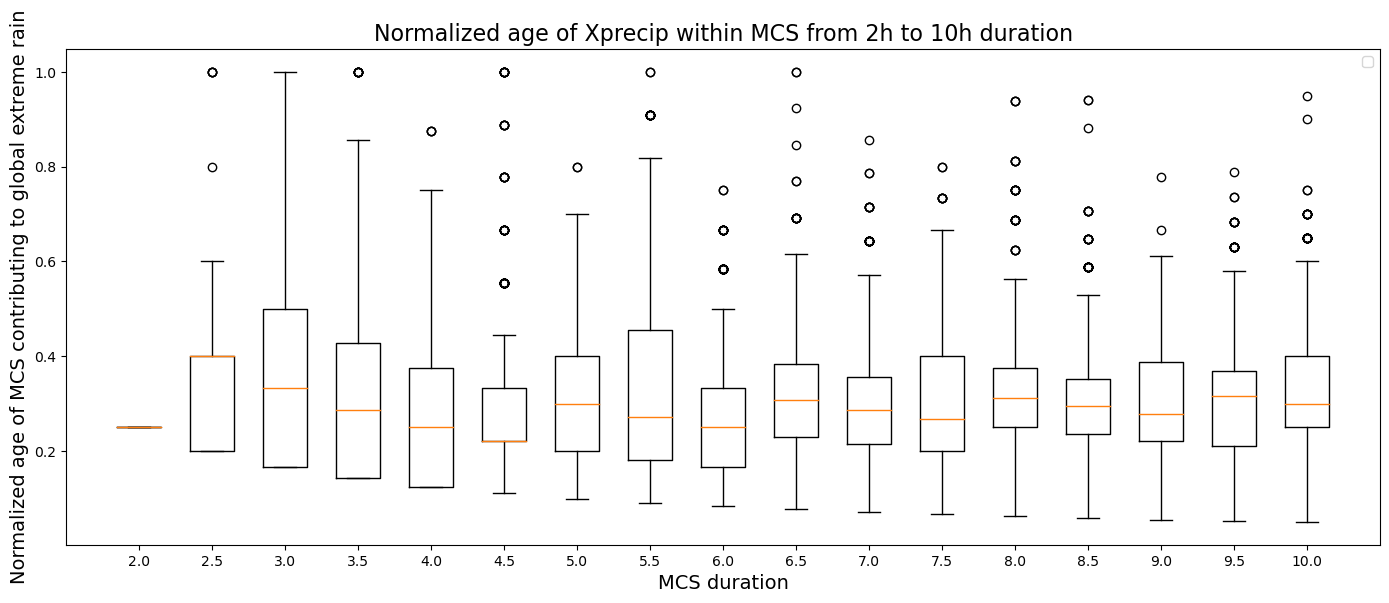

In [43]:
%matplotlib inline

MCS_duration_2h_to_10h = np.arange(2, 10.5, 1/2)

fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
ax.boxplot(ages_per_duration, positions = MCS_duration_2h_to_10h, widths = 0.3)


ax.set_xlabel("MCS duration", fontsize = 14)
ax.set_ylabel("Normalized age of MCS contributing to global extreme rain", fontsize = 14)
plt.legend()
plt.title("Normalized age of Xprecip within MCS from 2h to 10h duration", fontsize = 16)
plt.tight_layout()
plt.show()


## Check nan over MCS (I'm insecure, am I not)

In [27]:
from myFuncs import count_rel_nan

path_data = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'perc_MCS_over_rain_'+stringSST+'.pkl'

# check if perc_MCS_over_rain is already computed and saved in homedata 
if os.path.isfile(os.path.join(path_data, filename)):
    # File exists, load the object
    with open(os.path.join(path_data, filename), 'rb') as file:
        perc_MCS_over_rain = pickle.load(file)
else: ## compute it
    perc_MCS_over_rain = []
    for i,bin_loc in enumerate(dist_SAM_Prec.bin_locations):
        
        #print(np.round(dist_SAM_Prec.ranks[i], 4), len(x)) 
        ## Retrieve array of (x,y,t)s per bins that correspond to native precipitations 
        idxs_subs = np.unravel_index(bin_loc, ds_SAM_shape)

        ## Get the labels of MCS for these (x,y,t)s
        labels = label_mask.values[idxs_subs] ## label is nan if there is no MCS over this idx
        perc_MCS_over_rain.append(1-count_rel_nan(labels))  
    # and save it 
    with open(os.path.join(path_data, filename), 'wb') as file:
        pickle.dump(perc_MCS_over_rain, file)

check that the curve bounds match
x bounds: 0.0 99.99900000000001
y bounds: 0.0 2755.6696372843144



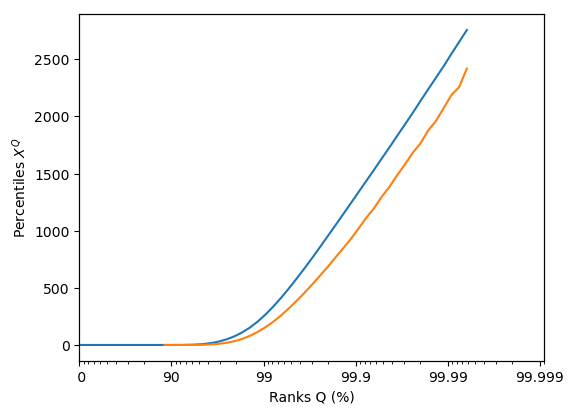

In [28]:
%matplotlib inline
fig,ax = plt.subplots(ncols=1,figsize=(6,4.5))

ranks = dist_SAM_Prec.ranks
perc = dist_SAM_Prec.percentiles

#--- on IL x axis
ax_show = ax.twiny()

#- set frame
setXaxisIL(ax,ranks)

#- show data
showData(ax_show,ranks,perc, rankmin=0, rankmax = 99.9999)
showData(ax_show, ranks, perc*perc_MCS_over_rain, rankmin=0, rankmax = 99.9999)

#- labels
ax.set_xlabel('Ranks Q (%)')
ax.set_ylabel('Percentiles $X^Q$')

print('check that the curve bounds match')
print('x bounds:',ranks[0],ranks[-1])
print('y bounds:',perc[0],perc[-1])
print()

In [36]:
perc_MCS_over_rain[11]

0.02136910000000003